In [ ]:
library(LDlinkR)
library(tidyverse)
library(data.table)
library(parallel)
library(GenomicRanges)
library(rtracklayer)
library(locuszoomr)
library(EnsDb.Hsapiens.v75)
library(ggpubr)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(gridExtra)
library(rjson)
library(cowplot)
library(patchwork)

In [3]:
## gene id-name map
gene_id_map = fread('../data/1M-scBloodNL/gene_id_name.allchrom.csv', sep='\t')

In [4]:
sorted_cell_types = c('B', 'CD4T', 'CD8T', 'NK', 'monocyte', 'DC')
sorted_cell_names = c('B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC')

In [5]:
egenes_dict = fromJSON(file='../data/blood_data/1M/merged_sumstats/by_chrom_gene/lowres_egenes_1e-5_hij1e-10.json')    

# Nuclear, cytoplasm, ER

In [7]:
gene_list = c('ACTA2', 'AHI1', 'BACH2', 'BATF3', 'CCDC85B', 'CENPU', 'CENPW', 'CTSW', 'DDX6', 'DGKQ', 'DRAP1', 'ETS1', 'ETV7',
             'FIBP', 'GATA3', 'GPX1', 'HHEX', 'IRF7', 'JAZF1', 'LBH', 'LYST', 'MPHOSPH9', 'NCKIPSD', 'NUTF2', 'PHF5A', 'PLCL1',
             'PPP5C', 'PRKCB', 'RGS14', 'RPS26', 'SESN3', 'SHMT1', 'SKAP2', 'SLC2A4RG', 'SNRPC', 'SP140', 'UBASH3A', 'UBE2L3',
             'ULK3', 'XBP1', 'ZFP36L1', 'ZFP90', 'ZNF652')

In [8]:
all_ibsep_egene_ids = c()
all_sc_egene_ids = c()
all_sc2_egene_ids = c()
for(ct in names(egenes_dict)){
    all_ibsep_egene_ids = c(all_ibsep_egene_ids, egenes_dict[[ct]][['1M-Blood-IBSEP']])
    all_sc_egene_ids = c(all_sc_egene_ids, egenes_dict[[ct]][['1M-Blood']])
    all_sc2_egene_ids = c(all_sc2_egene_ids, egenes_dict[[ct]][['OneK1K']])
}
all_ibsep_egene_ids = unique(all_ibsep_egene_ids)
all_sc_egene_ids = unique(all_sc_egene_ids)
all_sc2_egene_ids = unique(all_sc2_egene_ids)
print(length(all_ibsep_egene_ids))
print(length(all_sc_egene_ids))
print(length(all_sc2_egene_ids))

[1] 1808
[1] 328
[1] 1779


In [9]:
## geneid to genename
all_ibsep_egenes = unname(sapply(all_ibsep_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc_egenes = unname(sapply(all_sc_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc2_egenes = unname(sapply(all_sc2_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
print(length(all_ibsep_egenes))
print(length(all_sc_egenes))
print(length(all_sc2_egenes))

## merge egenes with gene list
merged_ibsep_egenes = intersect(gene_list, all_ibsep_egenes)
merged_sc_egenes = intersect(gene_list, all_sc_egenes)
merged_sc2_egenes = intersect(gene_list, all_sc2_egenes)
print(length(merged_ibsep_egenes))
print(length(merged_sc_egenes))
print(length(merged_sc2_egenes))

[1] 1808
[1] 328
[1] 1779
[1] 12
[1] 8
[1] 25


In [14]:
merged_ibsep_egenes

[1] "AHI1"   "CTSW"   "DDX6"   "GPX1"   "LBH"    "PPP5C"  "RPS26"  "SP140" 
 [9] "UBE2L3" "ULK3"   "XBP1"   "ZFP90"

In [15]:
merged_sc_egenes

[1] "AHI1"    "CTSW"    "DDX6"    "ETS1"    "GPX1"    "RPS26"   "XBP1"   
[8] "ZFP36L1"

In [16]:
intersect(merged_ibsep_egenes, merged_sc_egenes)
setdiff(merged_ibsep_egenes, merged_sc_egenes)
setdiff(merged_sc_egenes, merged_ibsep_egenes)

[1] "AHI1"  "CTSW"  "DDX6"  "GPX1"  "RPS26" "XBP1"

[1] "LBH"    "PPP5C"  "SP140"  "UBE2L3" "ULK3"   "ZFP90"

[1] "ETS1"    "ZFP36L1"

In [32]:
length(merged_ibsep_egenes)
length(merged_sc_egenes)

[1] 12

[1] 8

In [33]:
# 1: shared, positive, 2: novel, positive
# -1: shared, negative, -2: novel, negative
merged_ibsep_sc_egenes = union(merged_ibsep_egenes,merged_sc_egenes)
mat = matrix(nrow=length(merged_ibsep_sc_egenes), ncol=length(sorted_cell_types))
for(i in 1:nrow(mat)){
    gene = merged_ibsep_sc_egenes[i]
    gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
    for(j in 1:ncol(mat)){
        ct = sorted_cell_types[j]
        for(chr in 1:22){
            filename = sprintf('../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr%s/%s_%s_IBSEP_truncorr_pval1e-10.csv', 
                               chr, gene_id, ct)
            if(file.exists(filename)){
                break
            }
        }
        if(file.exists(filename)){
            eqtl_df = fread(filename, sep='\t') %>%
                dplyr::filter(!is.na(PVAL_BLUE)) %>%
                dplyr::filter(!is.na(PVAL))
            if((gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 1, -1)
            }else if((gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & !(gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 2, -2)
            }else if(!(gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 3, -3)
            }else{
                mat[i, j] = 0
            }
            if((gene_id %in% egenes_dict[[ct]][['OneK1K']])){
                mat[i, j] = mat[i, j] * 10
            }
        }else{
            mat[i, j] = 0
        }
    }
}

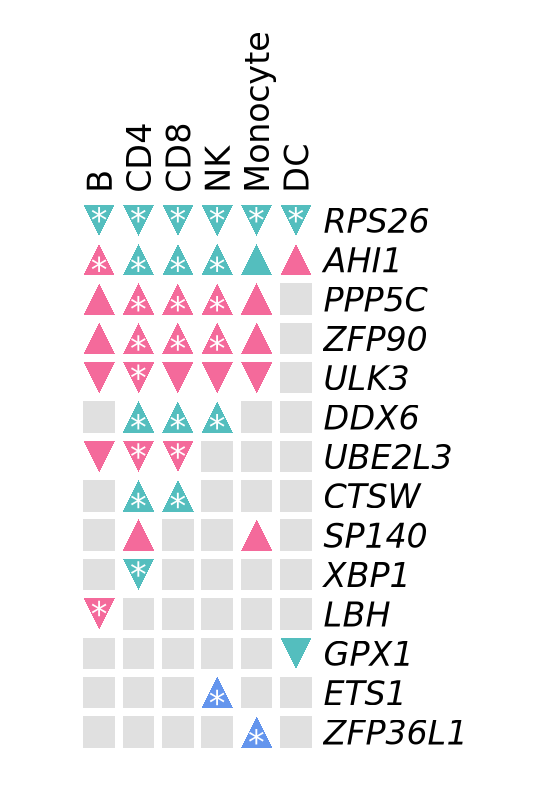

In [39]:
## 1m, ibsep
options(repr.plot.width=2.7, repr.plot.height=4, repr.plot.res=200)

c0 = "#E0E0E0" # null
c1 = '#54bebe' # shared with sc
c2 = '#f46a9b' # novel in ibsep
c3 = '#7FAFD2' # shared in 1k1k
c4 = '#F69541' # ibsep novel in 1k1k
c5 = '#6495ED' # only in sc
text_color = '#FFFFFF'
col_fun = colorRamp2(c(0, 1, 2, 3), c(c0, c1, c2, c5))
colors = structure(c(c0, c1, c2, c4), names = c(0,1,2,3))
w = ncol(mat)*unit(5, "mm")
h = nrow(mat)*unit(5, "mm")
ht = Heatmap(mat, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE, row_order=c(7,1,6,12,10,3,9,2,8,11,5,4,13,14),
        cell_fun = function(j, i, x, y, width, height, fill) {
            if(mat[i, j]==0){
                grid.rect(x=x, y=y, width=unit(4, 'mm'), height=unit(4, 'mm'),
                         gp = gpar(fill = c0, col = NA))
            }else if(mat[i, j]>0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                # message(sprintf('(%s, %s), (%s, %s), (%s, %s)', x1, y1, x2, y2, x3, y3))
                if((mat[i, j]==1) | (mat[i, j]==10)){
                    color = col_fun(1)
                }else if((mat[i, j]==2) | (mat[i, j]==20)){
                    color = col_fun(2)
                }else{
                    color = col_fun(3)
                }
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = color, col = NA))
                if(mat[i, j]>=10){
                    grid.text('*', x=x, y=unit(as.numeric(y)*as.numeric(h)-1.2,'mm'), gp=gpar(col=text_color))
                }    
            }else if(mat[i, j]<0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                if((abs(mat[i, j])==1) | (abs(mat[i, j])==10)){
                    color = col_fun(1)
                }else if((abs(mat[i, j])==2) | (abs(mat[i, j])==20)){
                    color = col_fun(2)
                }else{
                    color = col_fun(3)
                }
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = color, col = NA))
                if(mat[i, j]<=-10){
                    grid.text('*', x=x, y=unit(as.numeric(y)*as.numeric(h)+0.1,'mm'), gp=gpar(col=text_color))
                }    
            }
           },
        right_annotation=rowAnnotation(labels = anno_text(merged_ibsep_sc_egenes, which='row', 
                                                          gp = gpar(fontsize = 12, fontfamily='ArialMT', fontface = "italic"))),
        top_annotation=columnAnnotation(labels = anno_text(sorted_cell_names, 
                                                              which='column', gp = gpar(fontsize = 12, fontfamily='ArialMT'),
                                                          just='left', location=unit(0, 'npc'))),
        width = w, height = h, column_gap = unit(0, "mm"), border = FALSE, show_column_names=TRUE,
        show_heatmap_legend=FALSE
        )
draw(ht)


# Surface, membrane

In [42]:
gene_list = c('BLK', 'BTN3A1', 'CCR6', 'CD247', 'CD27', 'CD37', 'CD6', 'CD63', 'CD83', 'CLEC2D', 'CLECL1', 'CRHR1', 'CTLA4', 'DSE', 'FCRL3', 
             'GNG8', 'GPR18', 'IFNGR2', 'IL12RB2', 'IL18R1', 'IL2RA', 'ITGA4', 'LRRC37A2', 'LY9', 'MMEL1', 'PTGIR', 'RGS1', 'SCAMP3', 
             'SLC15A2', 'SLC44A2', 'TMEN258', 'TNFRSF14', 'UBE2D3')

In [43]:
all_ibsep_egene_ids = c()
all_sc_egene_ids = c()
all_sc2_egene_ids = c()
for(ct in names(egenes_dict)){
    all_ibsep_egene_ids = c(all_ibsep_egene_ids, egenes_dict[[ct]][['1M-Blood-IBSEP']])
    all_sc_egene_ids = c(all_sc_egene_ids, egenes_dict[[ct]][['1M-Blood']])
    all_sc2_egene_ids = c(all_sc2_egene_ids, egenes_dict[[ct]][['OneK1K']])
}
all_ibsep_egene_ids = unique(all_ibsep_egene_ids)
all_sc_egene_ids = unique(all_sc_egene_ids)
all_sc2_egene_ids = unique(all_sc2_egene_ids)
print(length(all_ibsep_egene_ids))
print(length(all_sc_egene_ids))
print(length(all_sc2_egene_ids))

[1] 1808
[1] 328
[1] 1779


In [44]:
## geneid to genename
all_ibsep_egenes = unname(sapply(all_ibsep_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc_egenes = unname(sapply(all_sc_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc2_egenes = unname(sapply(all_sc2_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
print(length(all_ibsep_egenes))
print(length(all_sc_egenes))
print(length(all_sc2_egenes))

## merge egenes with gene list
merged_ibsep_egenes = intersect(gene_list, all_ibsep_egenes)
merged_sc_egenes = intersect(gene_list, all_sc_egenes)
merged_sc2_egenes = intersect(gene_list, all_sc2_egenes)
print(length(merged_ibsep_egenes))
print(length(merged_sc_egenes))
print(length(merged_sc2_egenes))

[1] 1808
[1] 328
[1] 1779
[1] 7
[1] 0
[1] 12


In [47]:
intersect(merged_ibsep_egenes, merged_sc_egenes)
setdiff(merged_ibsep_egenes, merged_sc_egenes)
setdiff(merged_sc_egenes, merged_ibsep_egenes)

character(0)

[1] "BTN3A1"  "CD247"   "CD37"    "CD63"    "ITGA4"   "SCAMP3"  "SLC44A2"

character(0)

In [48]:
# 1: shared, positive, 2: novel, positive
# -1: shared, negative, -2: novel, negative
merged_ibsep_sc_egenes = union(merged_ibsep_egenes,merged_sc_egenes)
mat = matrix(nrow=length(merged_ibsep_sc_egenes), ncol=length(sorted_cell_types))
for(i in 1:nrow(mat)){
    gene = merged_ibsep_sc_egenes[i]
    gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
    for(j in 1:ncol(mat)){
        ct = sorted_cell_types[j]
        for(chr in 1:22){
            filename = sprintf('../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr%s/%s_%s_IBSEP_truncorr_pval1e-10.csv', 
                               chr, gene_id, ct)
            if(file.exists(filename)){
                break
            }
        }
        if(file.exists(filename)){
            eqtl_df = fread(filename, sep='\t') %>%
                dplyr::filter(!is.na(PVAL_BLUE)) %>%
                dplyr::filter(!is.na(PVAL))
            if((gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 1, -1)
            }else if((gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & !(gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 2, -2)
            }else if(!(gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 3, -3)
            }else{
                mat[i, j] = 0
            }
            if((gene_id %in% egenes_dict[[ct]][['OneK1K']])){
                mat[i, j] = mat[i, j] * 10
            }
        }else{
            mat[i, j] = 0
        }
    }
}

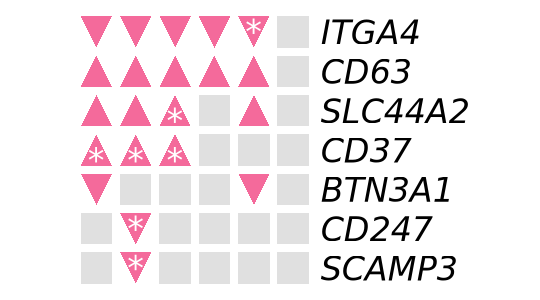

In [54]:
## 1m, ibsep
options(repr.plot.width=2.7, repr.plot.height=1.5, repr.plot.res=200)

c0 = "#E0E0E0" # null
c1 = '#54bebe' # shared with sc
c2 = '#f46a9b' # novel in ibsep
c3 = '#7FAFD2' # shared in 1k1k
c4 = '#F69541' # ibsep novel in 1k1k
c5 = '#6495ED' # only in sc
text_color = '#FFFFFF'
col_fun = colorRamp2(c(0, 1, 2, 3), c(c0, c1, c2, c5))
colors = structure(c(c0, c1, c2, c4), names = c(0,1,2,3))
w = ncol(mat)*unit(5, "mm")
h = nrow(mat)*unit(5, "mm")
ht = Heatmap(mat, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE, row_order=c(5,4,7,3,1,2,6),
        cell_fun = function(j, i, x, y, width, height, fill) {
            if(mat[i, j]==0){
                grid.rect(x=x, y=y, width=unit(4, 'mm'), height=unit(4, 'mm'),
                         gp = gpar(fill = c0, col = NA))
            }else if(mat[i, j]>0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                if((mat[i, j]==1) | (mat[i, j]==10)){
                    color = col_fun(1)
                }else if((mat[i, j]==2) | (mat[i, j]==20)){
                    color = col_fun(2)
                }else{
                    color = col_fun(3)
                }
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = color, col = NA))
                if(mat[i, j]>=10){
                    grid.text('*', x=x, y=unit(as.numeric(y)*as.numeric(h)-1.2,'mm'), gp=gpar(col=text_color))
                }    
            }else if(mat[i, j]<0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                if((abs(mat[i, j])==1) | (abs(mat[i, j])==10)){
                    color = col_fun(1)
                }else if((abs(mat[i, j])==2) | (abs(mat[i, j])==20)){
                    color = col_fun(2)
                }else{
                    color = col_fun(3)
                }
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = color, col = NA))
                if(mat[i, j]<=-10){
                    grid.text('*', x=x, y=unit(as.numeric(y)*as.numeric(h)+0.1,'mm'), gp=gpar(col=text_color))
                }    
            }
           },
        right_annotation=rowAnnotation(labels = anno_text(merged_ibsep_sc_egenes, which='row', 
                                                          gp = gpar(fontsize = 12, fontfamily='ArialMT', fontface = "italic"))),
        width = w, height = h, column_gap = unit(0, "mm"), border = FALSE, show_column_names=FALSE,
        show_heatmap_legend=FALSE
        )
draw(ht)

# Locuszoom: CD37

In [78]:
ct = 'B'
gene = 'CD37'
gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
for(chr in 1:22){
    if(file.exists(sprintf('../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr%s/%s_%s_IBSEP_truncorr_pval1e-10.csv', 
                               chr, gene_id, ct))){
        gene_chr = chr
        break
    }
}
gene_chr
gene_id

[1] 19

[1] "ENSG00000104894"

In [79]:
eqtl_df = fread(sprintf('../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr%s/%s_%s_IBSEP_truncorr_pval1e-10.csv', 
                               chr, gene_id, ct), sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))

In [80]:
subct = 'bmem'
onek1k_all = fread(sprintf('../data/blood_data/1M/merged_sumstats/sub_celltypes/%s.txt.gz', subct), sep='\t')


In [81]:
onek1k_df = onek1k_all[onek1k_all$GENEID_1M==gene_id] %>%
    dplyr::filter(!is.na(PVAL_1K1K))
dim(onek1k_df)

[1] 750  20

In [84]:
min(eqtl_df$BP)
max(eqtl_df$BP)
eqtl_df$CHR[1]

[1] 49742632

[1] 49942314

[1] 19

In [85]:
loc_eqtl <- locus(data=eqtl_df, chrom='CHR', pos='BP', p='PVAL', xrange=c(49732632, 49952314), seqname=19, ens_db = "EnsDb.Hsapiens.v75")
loc_eqtl <- link_LD(loc_eqtl, token = "7be0fab0c5d8")

chromosome 19, position 49732632 to 49952314

360 SNPs/datapoints

Obtaining LD on 360 SNPs


In [86]:
loc_ibsep <- locus(data=eqtl_df, chrom='CHR', pos='BP', p='PVAL_BLUE', xrange=c(49732632, 49952314), seqname=19, ens_db = "EnsDb.Hsapiens.v75")
loc_ibsep <- link_LD(loc_ibsep, token = "7be0fab0c5d8")

chromosome 19, position 49732632 to 49952314

360 SNPs/datapoints

Obtaining LD on 360 SNPs


In [87]:
loc_1k1k <- locus(data=onek1k_df, chrom='CHR', pos='BP', p='PVAL_1K1K', labs='SNP_1M', xrange=c(49732632, 49952314), seqname=19, ens_db = "EnsDb.Hsapiens.v75")
loc_1k1k <- link_LD(loc_1k1k, token = "7be0fab0c5d8")

chromosome 19, position 49732632 to 49952314

750 SNPs/datapoints

Obtaining LD on 750 SNPs

LDlink server is working...




In [88]:
loc_eqtl$index_snp
loc_ibsep$index_snp
loc_1k1k$index_snp

[1] "rs59181603"

[1] "rs8108669"

[1] "rs1465697"

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
4 tracks needed to show all genes



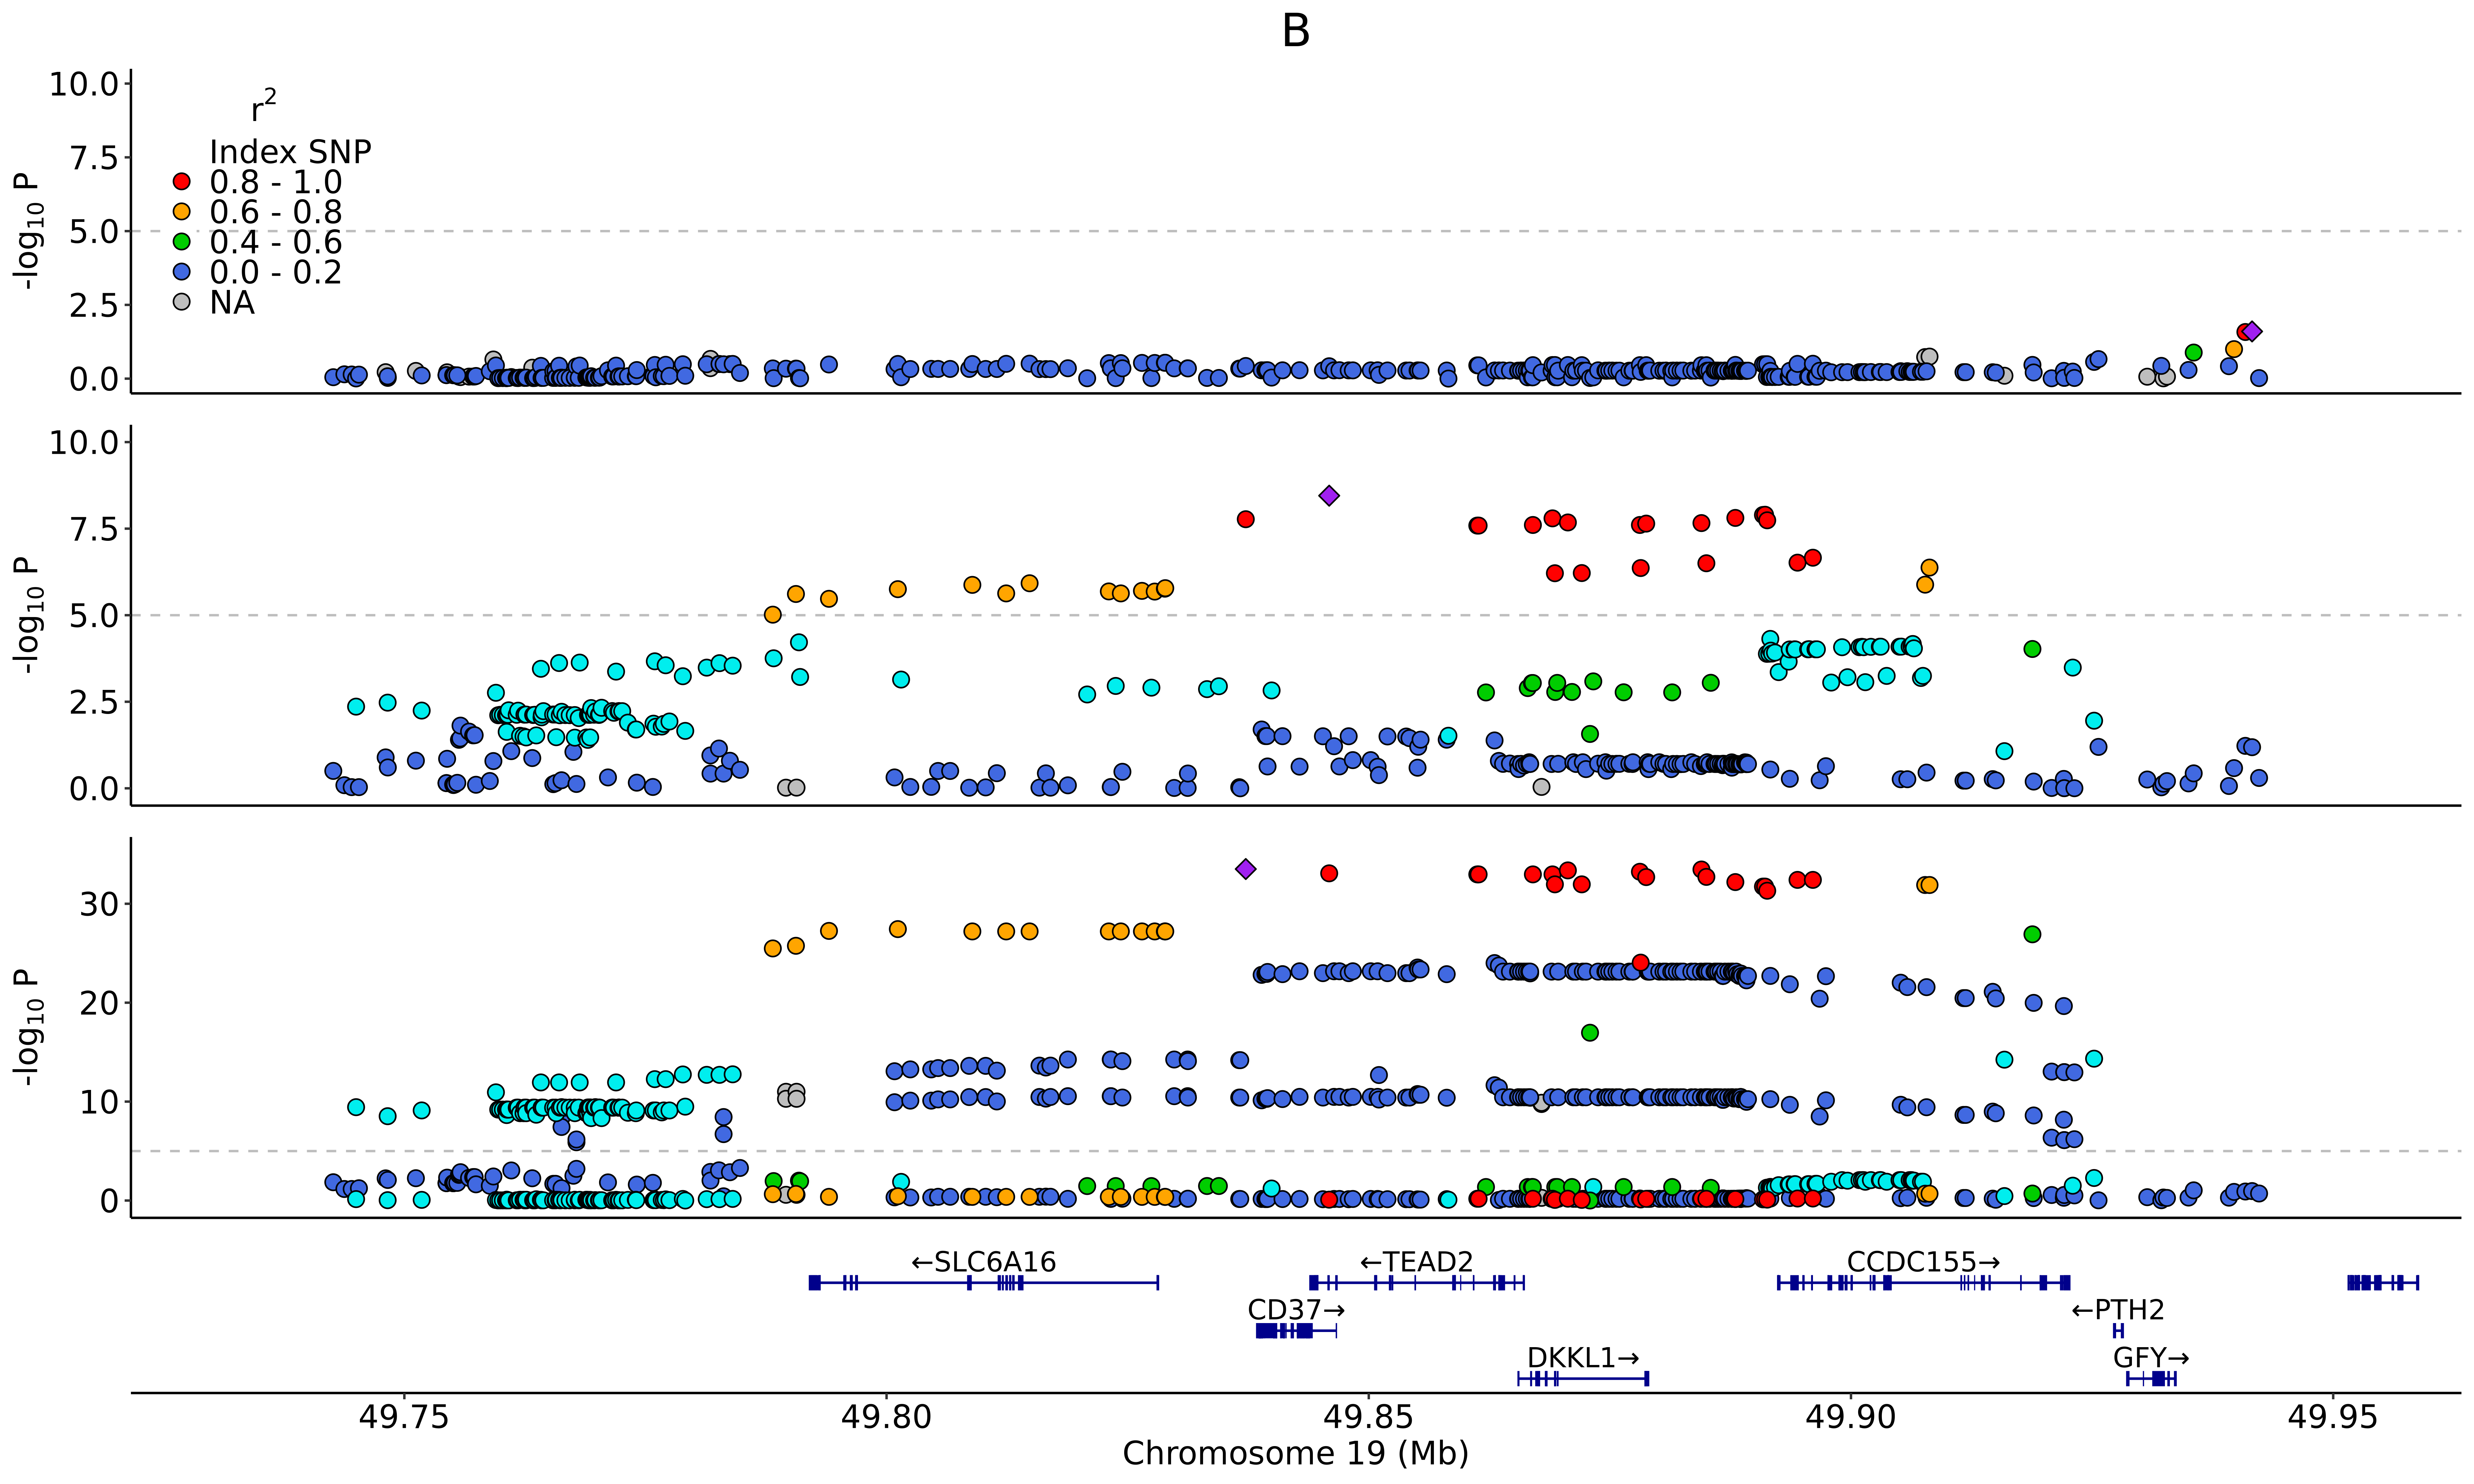

In [89]:
options(repr.plot.width=15, repr.plot.height=9, repr.plot.res=500)
ymax = 10
ymax2 = 35
ycut = 5
text_size = 14
axis_size = 18
title_size = 20
s = 3
p1 <- gg_scatter(loc_eqtl, labels=NULL, xticks = FALSE, legend_pos='topleft', size=s, pcutoff=1e-5) + ggtitle(ct) + 
    ylim(c(0, ymax)) + geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size), plot.title = element_text(color="black", size=title_size, hjust=0.5),
          legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p2 <- gg_scatter(loc_ibsep, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ylim(c(0, ymax)) + 
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p3 <- gg_scatter(loc_1k1k, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) +  ylim(c(0, ymax2)) +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
g <- gg_genetracks(loc_ibsep, maxrows=3, filter_gene_biotype='protein_coding', cex.text=1.0) + 
    theme(axis.text.x=element_text(size=text_size), axis.title.x=element_text(size=text_size))

plot_grid(p1, p2, p3, g, ncol = 1, rel_heights = c(2.5, 2.5, 2.5, 1.5), align = "v")